In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

CENTER = np.array([0,0,0])

pos = {'x': 170985.74339150003, 'y': -79702.51783586807, 'z': 55859.88429521968}
R = np.sqrt(np.square(np.array([pos['x'], pos['y'], pos['z']]) - CENTER).sum())
R

196745.88297089242

In [3]:
data = "/Users/youngsam/Code/random/Firefly/src/firefly/static/data/FIRESampleData/TweenParams.json"
with open(data) as f:
    data = json.load(f)
    
    
positions = np.array([list(d.values()) for d in data['position']])
rotations = np.array([list(d.values()) for d in data['rotation']])

%matplotlib inline
def plot(d):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(d[:,1], 'o-', alpha=0.1)
    ax.plot(d[:,0], 'o-', alpha=0.1)
    ax.plot(d[:,2], 'o-', alpha=0.1)
    plt.plot(np.sqrt(np.square(d - CENTER).sum(axis=1)), 'o-', alpha=0.1)
    # plt.axhline(R, color='k', linestyle='--')
    plt.show()

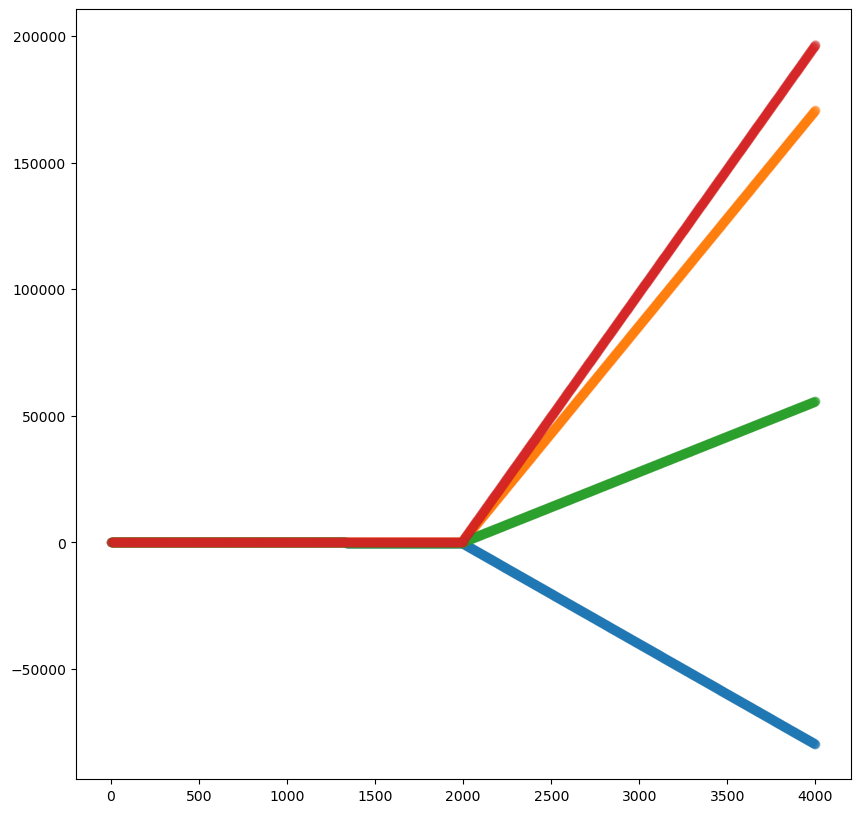

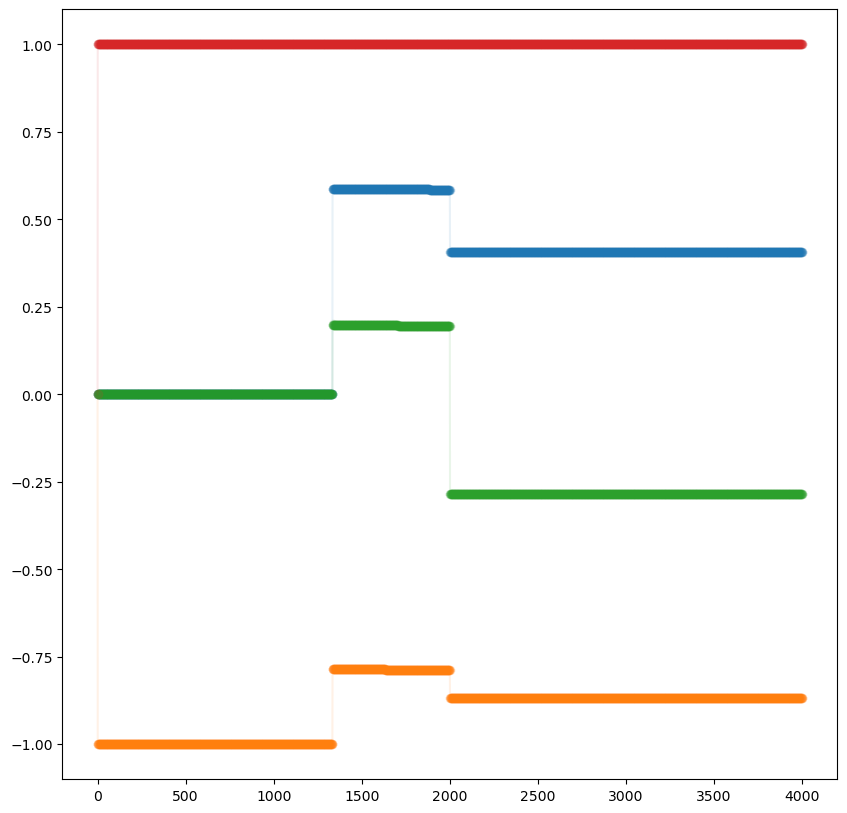

In [4]:
plot(positions)
plot(rotations)

In [57]:
def vector(v):
    return {'x': v[0], 'y': v[1], 'z': v[2]}

def tweenParamsFromPositions(positions, rotations=None, times=None,
                             loop=True, loaded=True):
    tweenParams = {"position": [], "rotation": [], "duration": [],
                   "loop": loop, "loaded": loaded}
    rotations = np.zeros_like(positions) if rotations is None else rotations
    if isinstance(times, (float, int)):
        times = times*np.ones_like(positions[:,0])
    elif times is None:
        times = 30*np.ones_like(positions[:,0])
    
    for i in range(len(positions)):
        if np.linalg.norm(positions[i]) == 0:
            rotation = rotations[i]
        else:
            rotation = -positions[i]/np.linalg.norm(positions[i]) # rotation vector to point to center!
        
        
        tweenParams['position'].append(vector(positions[i]))
        tweenParams['rotation'].append(vector(rotation))
        tweenParams['duration'].append(int(times[i]))
        
    return tweenParams

def save(dict):
    with open('../static/data/FIRESampleData/TweenParams.json', 'w') as f:
        json.dump(dict, f, indent=4)

In [ ]:
# stops on our cosmic journey
new_positions = np.array([
    
    # spend a minute on these three
    [0,0,0],            # start at origin  -> 20 sec
    [150, 0, 0],        # move 150 in x    -> 20 sec
    [130, -97, -33],    # rotate a lil     -> 20 sec
    [1080.25273935, -503.54410559,  352.91125349],
    [1080.25273935, -503.54410559,  352.91125349]*mult
    # then another minute on this
])

multiplier = R/np.sqrt(np.square(positions[3]).sum())
# then another minute on this
new_positions = np.concatenate([new_positions, [1194, -347, 26.3]*np.linspace(1, multiplier, 2000)[:, np.newaxis]])

new_times = [60000/3]*3 + [60000/20]*20
new_times = np.array(new_times)
print('total time', new_times.sum()/1000/60, 'minutes')


In [ ]:
1243*np.array(list({'x': 170985.74339150003, 'y': -79702.51783586807, 'z': 55859.88429521968}.values()))/R

In [58]:
v1 = np.array([150, 1, 1])
v2 = np.array([130, -97, -33])
v2 = np.array([-91, 13, -87])
v3 = np.array([1080.25273935, -503.54410559,  352.91125349])


# 0 to 150 (20 sec --> 20,000 ms --> 667 steps)
# [150,0,0]*[0,0.02,0.04,...,1]
steps = np.arange(0,1+1/667,1/666)[:, np.newaxis]
_0t150 = v1*steps
_0t150_time = [30]*len(_0t150)

# [150, 0, 0] to [130, -97, -33] (20 sec --> 20,000 ms --> 667 steps again)
vecchange = (v2 - v1)/666
_150t130 = v1 + vecchange*steps
_150t130_time = [30]*len(_150t130)

# [130, -97, -33] to [1080.25273935, -503.54410559,  352.91125349] (20 sec --> 20,000 ms
# --> 667 steps again)
vecchange = (v3 - v2)/666
_130t1080 = v2 + vecchange*steps
_130t1080_time = [30]*len(_130t1080)

print('total time so far:', sum(_0t150_time + _150t130_time + _130t1080_time)/1000/60, 'minutes')

total time so far: 1.0005 minutes


In [59]:
# [1080.25273935, -503.54410559,  352.91125349] to final destination!
# 1 whole minute --> 60,000 ms --> 2000 steps
steps = np.arange(0,1+1/2000,1/1999)[:, np.newaxis]
norm = np.sqrt(np.square(v3).sum())
ratio = R/norm
vecchange = v3*ratio - v3
_1080tfinal = v3 + vecchange*steps
_1080tfinal_time = [30]*len(_1080tfinal)

print('total time:', sum(_0t150_time + _150t130_time + _130t1080_time + _1080tfinal_time)/1000/60, 'minutes')

total time: 2.0005 minutes


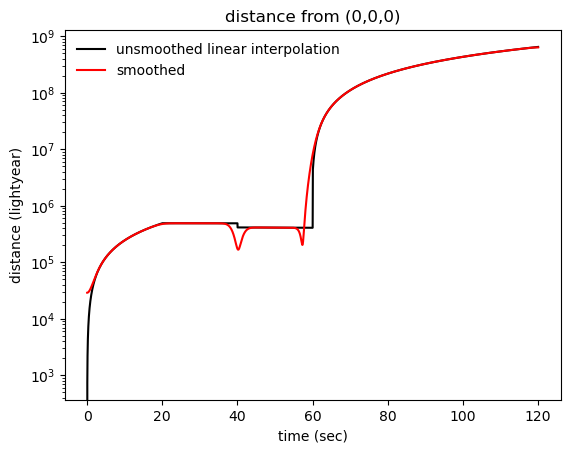

In [60]:
# put it all together
from scipy.ndimage import gaussian_filter

final_positions = np.concatenate([_0t150, _150t130, _130t1080, _1080tfinal])
final_times = _0t150_time + _150t130_time + _130t1080_time + _1080tfinal_time
final_times = np.array(final_times)

Rs = np.sqrt(np.square(final_positions).sum(axis=1))
ts = np.cumsum(final_times)/1000
plt.plot(ts, Rs*3261.56, label='unsmoothed linear interpolation', c='k')

final_positions[:, 0] = gaussian_filter(final_positions[:, 0], sigma=50)
final_positions[:, 1] = gaussian_filter(final_positions[:, 1], sigma=50)
final_positions[:, 2] = gaussian_filter(final_positions[:, 2], sigma=50)

Rs = np.sqrt(np.square(final_positions).sum(axis=1))
ts = np.cumsum(final_times)
plt.title('distance from (0,0,0)')
plt.plot(ts/1000, Rs*3261.56, c='r', label='smoothed')
plt.legend(frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('distance (lightyear)')
plt.yscale('log')
plt.show()

In [61]:
save(tweenParamsFromPositions(final_positions, times=(2*final_times).astype(np.float32), loop=True, loaded=True))